In [62]:
#imports
from datetime import datetime as dt

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder, FunctionTransformer
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score



from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

### Loading Datasets

In [63]:
# file path
file_path="C:/Users/Davie/Desktop/introduction-to-power-bi/"

In [64]:
#load demographic data
demographic=pd.read_excel(file_path+"KPMG/KPMG_VI_New_raw_data_update_final.xlsx",sheet_name='CustomerDemographic', index_col=False, header=0, usecols="A:M", skiprows=1)

In [65]:
#load customer address
address=pd.read_excel(file_path+"KPMG/KPMG_VI_New_raw_data_update_final.xlsx",sheet_name='CustomerAddress', index_col=False, header=0, usecols="A:F", skiprows=1)

In [66]:
#load transaction data
transactions=pd.read_excel(file_path+"KPMG/KPMG_VI_New_raw_data_update_final.xlsx",sheet_name='Transactions', index_col=False, header=0, usecols="A:M", skiprows=1)

### Merging the datasets

In [67]:
#merge demographic data with customer address
demographic_address=pd.merge(demographic, address, on='customer_id', how='inner')

In [68]:
#merged all the 3 datasets
demographic_address_transactions=pd.merge(demographic_address, transactions, on='customer_id', how='inner')

In [69]:
#drop duplicates and ulls
df=demographic_address_transactions.drop_duplicates().dropna()

In [70]:
#make copy of the data
data=df.copy().drop_duplicates(subset=['customer_id'])

### Feature engineering

In [71]:
#calculate product margin
data['product_margin']=(data['list_price']-data['standard_cost'])/data['list_price']

In [72]:
# Calculate age

# convert DOB to datetime
data['DOB']=pd.to_datetime(data['DOB'])
# Get the current date
current_date = pd.to_datetime('today')
# Calculate age using apply and a lambda function to handle the year difference
data['age'] = df['DOB'].apply(lambda x: current_date.year - x.year - ((current_date.month, current_date.day) < (x.month, x.day)))

In [73]:
# Define age bins and labels
bins = [0, 20, 30, 40, 50, 60, 70, 100]
labels = ['<20','20-30','30-40','40-50','50-60','60-70', '>70']

# Create age groups
data['age_group'] = pd.cut(data['age'], bins=bins, labels=labels, right=False)

In [74]:
# Date of transaction
data['transaction_date'] = pd.to_datetime(data['transaction_date'])

# Extract the daya, monthand year from transaction_date
data['trans_day'] = data['transaction_date'].dt.day
data['trans_month'] = data['transaction_date'].dt.month

In [75]:
# Replace values for gender and state in the entire DataFrame
data['gender'] = data['gender'].replace({'Femal': 'Female', 'F': 'Female'})
data['state']=data['state'].replace({'New South Wales':'NSW','Victoria':'VIC'})

In [76]:
# Define tenure ranges
bins = [0, 5, 10, 15, 25]
labels = ['<5','5-10', '10-15', '>15']

# Create age groups
data['tenure_period'] = pd.cut(data['tenure'], bins=bins, labels=labels, right=False)

In [77]:
# Define proterty valuation ranges
bins = [0, 3, 6, 9, 12]
labels = ['<3','3-6', '6-9', '>9']

# Create age groups
data['valuation_category'] = pd.cut(data['property_valuation'], bins=bins, labels=labels, right=False)

### Distribution for Bikes Purchased to be used as the target variable

<Axes: ylabel='Frequency'>

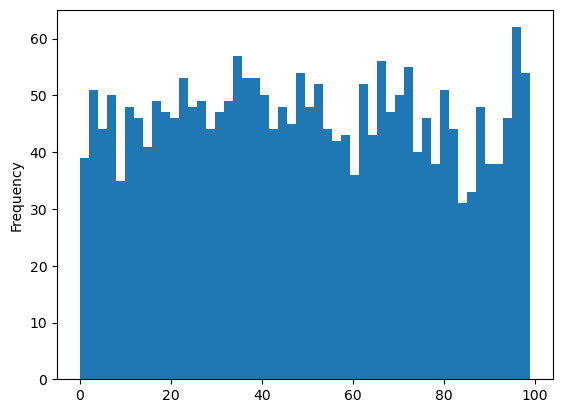

In [78]:
#histogram
data['past_3_years_bike_related_purchases'].plot.hist(bins=50)

<Axes: >

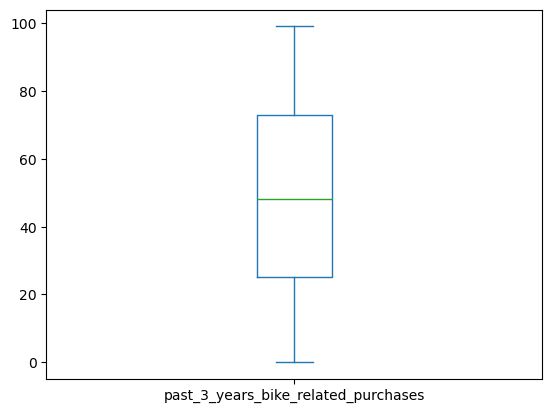

In [79]:
#box plot
data['past_3_years_bike_related_purchases'].plot.box()

### Columns

In [80]:
# Check new columns
data.columns

Index(['customer_id', 'first_name', 'last_name', 'gender',
       'past_3_years_bike_related_purchases', 'DOB', 'job_title',
       'job_industry_category', 'wealth_segment', 'deceased_indicator',
       'default', 'owns_car', 'tenure', 'address', 'postcode', 'state',
       'country', 'property_valuation', 'transaction_id', 'product_id',
       'transaction_date', 'online_order', 'order_status', 'brand',
       'product_line', 'product_class', 'product_size', 'list_price',
       'standard_cost', 'product_first_sold_date', 'product_margin', 'age',
       'age_group', 'trans_day', 'trans_month', 'tenure_period',
       'valuation_category'],
      dtype='object')

In [81]:
#select columns to use in the Model
cols=['customer_id', 'gender','age_group', 'state', 'job_industry_category', 'job_title','online_order', 'order_status' ,'wealth_segment',  
      'brand','product_line', 'product_class', 'product_size', 'tenure', 'tenure_period', 'past_3_years_bike_related_purchases', 
      'valuation_category', 'property_valuation', 'product_margin', ]

In [82]:
#select model columns
data=data[cols].dropna()

### Encoding, Setting target and feature variables

- Choose the encoding method based on the nature of your data and the requirements of your machine learning model. 
- `One-hot encoding` is suitable when there is no ordinal relationship between categories
- `label encoding` is useful when there is an ordinal relationship between categories. 
- **Example**
    - Label encoding for Ordinal Variables
    - `ordinal_mapping_prod_size = {'small': 0, 'medium': 1, 'large': 2} #product size`
    - `ordinal_data['product_size'] = ordinal_data['product_size'].map(ordinal_mapping_prod_size)`
    - `data.reset_index(drop=True, inplace=True)`  # Reset index of X without adding it as a new column
    - Select categorical columns `categorical_ordinal = ['product_class', 'product_size']`
    - `model_data_class = pd.concat([data_c, encoded_data], axis=1)`
    - Initialize LabelEncoder `label_encoder = LabelEncoder()`
    - Apply Label Encoding to each column `for col in categorical_ordinal:data_clean[col] = label_encoder.fit_transform(data_clean[col])`
- Always remember to handle unknown categories appropriately, especially when using one-hot encoding.

In [83]:
# Make copy of the data
classification_model_data=data.copy()

In [84]:
# Creating binary variable from continous variable
#threshold=classification_model_data['past_3_years_bike_related_purchases'].median()
#classification_model_data['purchase_bikes']=(classification_model_data['past_3_years_bike_related_purchases']>threshold).astype(int)

classification_model_data['purchase_bikes']=classification_model_data['past_3_years_bike_related_purchases'].apply(lambda x: 1 if x>0 else 0)

In [85]:
# Define and the target variable
features_X = classification_model_data.drop(columns=['purchase_bikes', 'past_3_years_bike_related_purchases', 'customer_id'])
target_y = classification_model_data['purchase_bikes']

In [86]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_X, target_y, test_size=0.2, random_state=42)

### Preprocessing

In [87]:
# Define categorical columns and numerical columns
categorical_features = ['gender', 'tenure_period','age_group','state', 'job_industry_category','job_title', 
                    'order_status', 'wealth_segment', 'brand', 'product_line', 'valuation_category', 'product_class', 'product_size']
numerical_features = ['product_margin', 'property_valuation', 'tenure'] 

# Combine preprocessing steps for numerical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]) #([], remainder='passthrough')

### Define Pipelines and Train the model

##### (a) Random Forest
- build a model to predict the likelihood of bike purchases based on demographic and product characteristics

In [93]:
# Create a pipeline with RandomForestClassifier
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

print('Classification Report:')
print(classification_report(y_test, y_pred, zero_division=0))

print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Accuracy: 99.32%
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.99      1.00      1.00       440

    accuracy                           0.99       443
   macro avg       0.50      0.50      0.50       443
weighted avg       0.99      0.99      0.99       443

Confusion Matrix:
[[  0   3]
 [  0 440]]


##### (b) Logistic Regression

- Logistic regression is used for classification tasks, (not regression). 
- Since we want to determine which demographic and product characteristics influences bike purchases or make customer to purchase the bike, logistic regression is appropriate.

In [89]:
# Create a pipeline with LogisticRegression
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000,random_state=42))
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_X, target_y, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'F1 Score: {f1_score(y_test, y_pred)}')
print(f'ROC AUC Score: {roc_auc_score(y_test, y_pred)}')

Accuracy: 0.9932279909706546
Precision: 0.9932279909706546
Recall: 1.0
F1 Score: 0.9966024915062288
ROC AUC Score: 0.5


##### (c) Decission Tree

In [90]:
# Create a pipeline with DecisionTreeClassifier
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_X, target_y, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

print('Classification Report:')
print(classification_report(y_test, y_pred))

print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Accuracy: 98.65%
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.99      0.99      0.99       440

    accuracy                           0.99       443
   macro avg       0.50      0.50      0.50       443
weighted avg       0.99      0.99      0.99       443

Confusion Matrix:
[[  0   3]
 [  3 437]]


### STOP

In [91]:
print('fffff'

SyntaxError: incomplete input (479674055.py, line 1)

##### LINEAR RGRESSION

In [ ]:
''# Preprocessing pipeline for numerical data
numerical_transformer = StandardScaler()

# Preprocessing pipeline for categorical data
#categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine preprocessing steps for numerical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features)
    ],
    remainder='passthrough'  # Keep all other columns as they are (already preprocessed/one-hot encoded)
)
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42))
])


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

print('Classification Report:')
print(classification_report(y_test, y_pred))

print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

# Visualize feature importances (coefficients)
# Get coefficients from the trained model
coefficients = model.named_steps['classifier'].coef_[0]

# Get feature names (numerical + already one-hot encoded features)
feature_names = numerical_features + [col for col in X.columns if col not in numerical_features]

# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Filter coefficients for positive influence
importance_df = importance_df[importance_df['Coefficient'] > 0]

# Sort the DataFrame by absolute value of coefficients
importance_df = importance_df.reindex(importance_df.Coefficient.abs().sort_values(ascending=False).index)

# Plot the feature importances
plt.figure(figsize=(10, 38))
plt.barh(importance_df['Feature'], importance_df['Coefficient'])
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importances in Logistic Regression')
plt.gca().invert_yaxis()
plt.show()'''

### RANDOM FOREST

In [ ]:
'''# Visualize feature importances
# Get feature importances from the trained model
feature_importances = model.named_steps['classifier'].feature_importances_

# Get feature names (numerical + already one-hot encoded features)
feature_names = numerical_features + [col for col in X.columns if col not in numerical_features]

# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 36))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances in Random Forest Classifier')
plt.gca().invert_yaxis()
plt.show()'''

##### DECISSION TREE

In [ ]:
'''# Preprocessing pipeline for numerical data
numerical_transformer = StandardScaler()

# Preprocessing pipeline for categorical data
#categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine preprocessing steps for numerical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features)
    ],
    remainder='passthrough'  # Keep all other columns as they are (already preprocessed/one-hot encoded)
)



# Visualize feature importances
# Get feature importances from the trained model
feature_importances = model.named_steps['classifier'].feature_importances_

# Get feature names (numerical + already one-hot encoded features)
feature_names = numerical_features + [col for col in X.columns if col not in numerical_features]

# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 38))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances in Decision Tree Classifier')
plt.gca().invert_yaxis()
plt.show()'''

##### LOGISTIC REGRESSION


In [ ]:
# Preprocessing pipeline for numerical data
numerical_transformer = StandardScaler()

# Combine preprocessing steps for numerical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features)
    ],
    remainder='passthrough'  # Keep all other columns as they already preprocessed/one-hot encoded
)



In [ ]:
# Interpret the model coefficients

# Get the feature names after one-hot encoding and scaling
feature_names = numerical_features + [col for col in X.columns if col not in numerical_features]

# Get the coefficients from the logistic regression model
coefficients = model.named_steps['classifier'].coef_[0]

# Create a DataFrame for the coefficients
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort by absolute value of the coefficient to see the most influential features
coef_df['Absolute Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Absolute Coefficient', ascending=False)

#coef_df.to_csv('coj.csv',index=False)

print(coef_df)

In [ ]:
# Filter coefficients for negative contribution to bike purchases
negative_coef_df = coef_df[coef_df['Coefficient'] < 0]

# Sort coefficients in ascending order (from most negative to least negative)
negative_coef_df = negative_coef_df.sort_values(by='Coefficient', ascending=False)

# Plot the coefficients for negative contribution to bike purchases
plt.figure(figsize=(10, 36))
plt.barh(negative_coef_df['Feature'], negative_coef_df['Coefficient'], color='salmon')
plt.xlabel('Coefficient')
plt.title('Logistic Regression Coefficients for Negative Contribution to Bike Purchases (Most Negative to Least Negative)')
plt.grid(axis='x')
plt.show()

In [ ]:
# Filter coefficients for positive influence
positive_coef_df = coef_df[coef_df['Coefficient'] > 0]

# Sort coefficients in descending order
positive_coef_df = positive_coef_df.sort_values(by='Coefficient', ascending=True)

# Plot the coefficients for positive influence
plt.figure(figsize=(10, 36))
plt.barh(positive_coef_df['Feature'], positive_coef_df['Coefficient'], color='skyblue')
plt.xlabel('Coefficient')
plt.title('Logistic Regression Coefficients for Positive Influence')
plt.grid(axis='x')
plt.show()

### REGRESSION

In [ ]:
# make copy
reg_data_model=data.copy()

In [ ]:
# Define numerical and categorical features
numerical_features = ['product_margin'] 
categorical_features = [col for col in reg_data_model.columns if col != 'past_3_years_bike_related_purchases' and col != 'product_margin']

In [ ]:
# Select relevant features and the target variable
X = reg_data_model.drop(columns=['past_3_years_bike_related_purchases'])
y = reg_data_model['past_3_years_bike_related_purchases']

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Preprocessing pipeline for numerical data
numerical_transformer = StandardScaler()

# Preprocessing pipeline for categorical data
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine preprocessing steps for specific columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define the model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R-squared: {r2}')

# Feature importance
# Get the feature names from the preprocessor
num_features = preprocessor.transformers_[0][2]
cat_features = preprocessor.transformers_[1][1].get_feature_names_out(categorical_features)
all_features = num_features + cat_features.tolist()

# Get the coefficients
coefficients = model.named_steps['regressor'].coef_

# Create a DataFrame for visualization
coef_df = pd.DataFrame({'Feature': all_features, 'Coefficient': coefficients})
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 38))
sns.barplot(x='Coefficient', y='Feature', data=coef_df)
plt.title('Feature Importance from Linear Regression')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.show()

- Use RandomForestRegressor when your target variable is a continuous value that you need to predict.
- Use RandomForestClassifier when your target variable is a categorical label or class.

In [ ]:
# make copy
ran_data_model=data.copy()

In [ ]:
# Define numerical and categorical features
numerical_features = ['product_margin'] 
categorical_features = [col for col in ran_data_model.columns if col != 'past_3_years_bike_related_purchases' and col != 'product_margin']

In [ ]:
# Select relevant features and the target variable
X = ran_data_model.drop(columns=['past_3_years_bike_related_purchases'])
y = ran_data_model['past_3_years_bike_related_purchases']

In [ ]:
# Preprocess data: one-hot encode categorical variables and scale numerical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Define the model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Evaluate the model
r_squared = model.score(X_test, y_test)
print(f'R-squared: {r_squared}')

# Feature importance
# Get the feature names from the preprocessor
num_features = preprocessor.transformers_[0][2]
cat_features = preprocessor.transformers_[1][1].get_feature_names_out(categorical_features)
all_features = num_features + cat_features.tolist()

# Get the feature importances
importances = model.named_steps['regressor'].feature_importances_

# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': all_features, 'Importance': importances})

# Set a threshold for feature importance
threshold = 0.001

# Filter features based on the threshold
important_features_df = importance_df[importance_df['Importance'] >= threshold]

# Sort the important features by their importance
important_features_df = important_features_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=important_features_df)
plt.title('Feature Importance from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()